In [1]:
from pandas import DataFrame, Grouper
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import sys

In [2]:
%%time
# import our own stuff
sys.path.append("../python/src")

from tools import read_water_data, extract_features, apply_historical_incomegroups_wb
from tools import get_oecd_iso3_code_mapping,apply_historical_incomegroups_oecd

from waterData import default_features

CPU times: user 71 ms, sys: 4.58 ms, total: 75.5 ms
Wall time: 75.3 ms


In [3]:
%%time
# set some options
#pd.set_option('display.max_rows', 600)
#pd.set_option('display.max_columns', 600)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', None)

datadir = "../data/"
cachedir = "../data/cache" 

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 2.62 µs


In [4]:
%%time

# read some data and get some mapping that may needs calculations

# the codemapping is generate over the full dataset to get all oecd-country-codes
# and from a fetch of the countries known to worldbank
codemapping = get_oecd_iso3_code_mapping(cachedir=cachedir,datadir=datadir)

# the data from oecd must be downloaded and saved as zips in the data-dir, check readme for links
oecddf = read_water_data(setname="fullset",datadir=datadir,cachedir=cachedir)


display("all data")
# tell me what it is
oecddf.describe()

Reading countrycode-mapping cached file: ../data/cache/oecdiso3.p
Reading Datafrom cached file: ../data/cache/fullset.p


'all data'

CPU times: user 11 s, sys: 3.38 s, total: 14.4 s
Wall time: 14.4 s


,USD_Commitment,USD_Disbursement,USD_Received,USD_Commitment_Defl,USD_Disbursement_Defl,USD_Received_Defl,USD_Adjustment,USD_Adjustment_Defl,USD_AmountUntied,USD_AmountPartialTied,...,TypeRepayment,NumberRepayment,Interest2,USD_Interest,USD_Outstanding,USD_Arrears_Principal,USD_Arrears_Interest,CapitalExpend,PSIflag,PSIAddType
count,3.051025e+06,3.506449e+06,1.980515e+06,3.051025e+06,3.506449e+06,1.980515e+06,54325.000000,54325.000000,1.822440e+06,963806.000000,...,542849.000000,553752.000000,328270.000000,1.232437e+06,867437.000000,620176.000000,628093.000000,32296.000000,2161.000000,711.000000
mean,1.732823e+00,9.959690e-01,4.593473e-01,2.103196e+00,1.056015e+00,4.927653e-01,-0.810849,-0.912068,1.016804e+00,0.339658,...,1.477022,1.869440,396.913882,2.375613e-01,8.368500,0.237621,0.283841,0.000090,1.987506,2.015471
std,2.047103e+01,1.487377e+01,7.843651e+00,2.414103e+01,1.565664e+01,8.306830e+00,12.451076,12.358834,1.542315e+01,6.633610,...,1.184970,0.551107,584.336396,3.609668e+00,74.482526,9.964379,5.574769,0.001934,0.111103,0.984979
min,-1.421530e+03,-2.258730e+02,-5.030000e-01,-1.300270e+03,-2.461000e+02,-6.852520e-01,-1995.000000,-1870.620000,-1.421530e+03,-1.787180,...,0.000000,0.000000,0.000000,-3.491230e+01,-0.507119,-3.033060,-0.149653,0.000000,1.000000,1.000000
25%,0.000000e+00,3.781470e-03,-0.000000e+00,0.000000e+00,3.927740e-03,-0.000000e+00,-0.089212,-0.093630,0.000000e+00,0.000000,...,1.000000,2.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,2.214890e-02,4.171300e-02,0.000000e+00,2.389890e-02,4.416200e-02,0.000000e+00,-0.010290,-0.010783,4.355780e-03,0.000000,...,1.000000,2.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000
75%,2.008640e-01,2.386590e-01,-0.000000e+00,2.280270e-01,2.531470e-01,0.000000e+00,-0.000900,-0.000928,1.263540e-01,0.000000,...,1.000000,2.000000,750.000000,4.892500e-02,1.292290,0.000000,0.000000,0.000000,2.000000,3.000000
max,6.585080e+03,7.188450e+03,3.690330e+03,7.209450e+03,7.209450e+03,3.637680e+03,0.004700,0.004720,4.138840e+03,2053.390000,...,5.000000,52.000000,20000.000000,1.460130e+03,24053.000000,4317.120000,1586.170000,0.100000,2.000000,3.000000


In [5]:
%%time

# filter out useless / unrelevant data
df = oecddf[oecddf['USD_Commitment'] != 0.0].copy()

df = df[df['USD_Commitment'].notnull()]

df = df[df['FlowCode'].isin(['13','11'])]

#df = df[df['RecipientCode'].isin(codemapping)]

df = df[df['CommitmentDate'] > datetime(year=1995,month=12,day=31)]
df = df[df['CommitmentDate'] < datetime(year=2019,month=1,day=1)]

# reduce to relevant features
df = extract_features(df,features=default_features)

# tell me what is left
df.describe()

CPU times: user 6.67 s, sys: 1.65 s, total: 8.32 s
Wall time: 8.33 s


,USD_Commitment_Defl,USD_Received_Defl,USD_GrantEquiv
count,1.448027e+06,511568.000000,365200.000000
mean,1.818964e+00,0.008469,0.836465
std,2.027189e+01,0.576570,21.663255
min,-1.094320e+03,0.000000,-44.771200
25%,1.575970e-02,0.000000,0.009716
50%,7.803210e-02,0.000000,0.044480
75%,4.050445e-01,-0.000000,0.204578
max,7.209450e+03,155.161000,6585.080000


In [6]:
%%time

df = apply_historical_incomegroups_oecd(df,datadir=datadir)

CPU times: user 5.55 s, sys: 593 ms, total: 6.14 s
Wall time: 6.14 s


In [7]:
%%time

df = apply_historical_incomegroups_wb(df,codemapping,datadir=datadir)

CPU times: user 6.75 s, sys: 751 ms, total: 7.5 s
Wall time: 7.51 s


CPU times: user 3.9 s, sys: 719 ms, total: 4.62 s
Wall time: 4.62 s


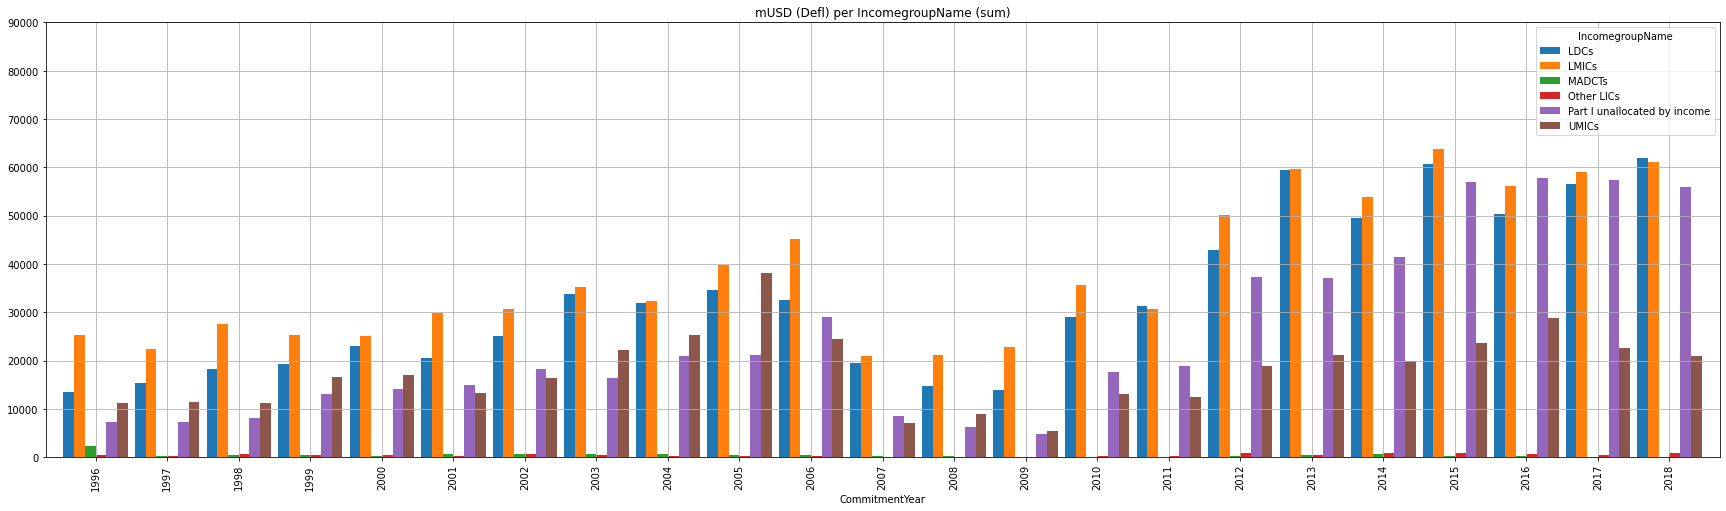

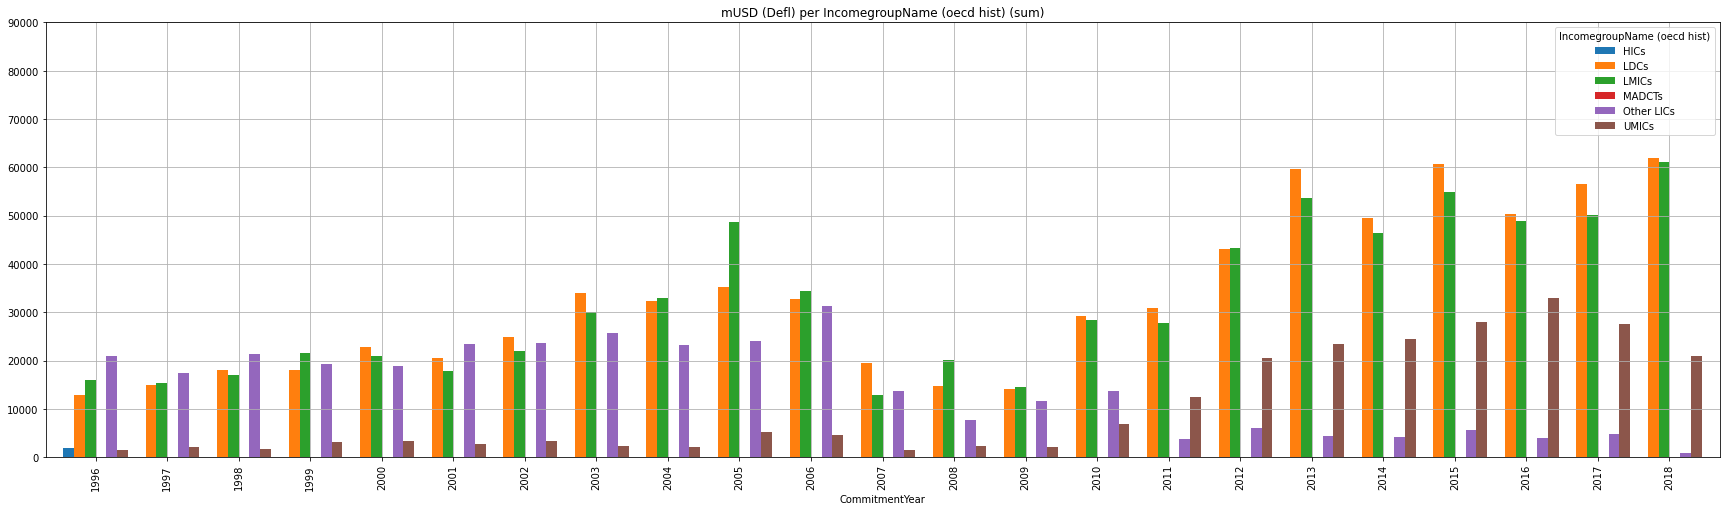

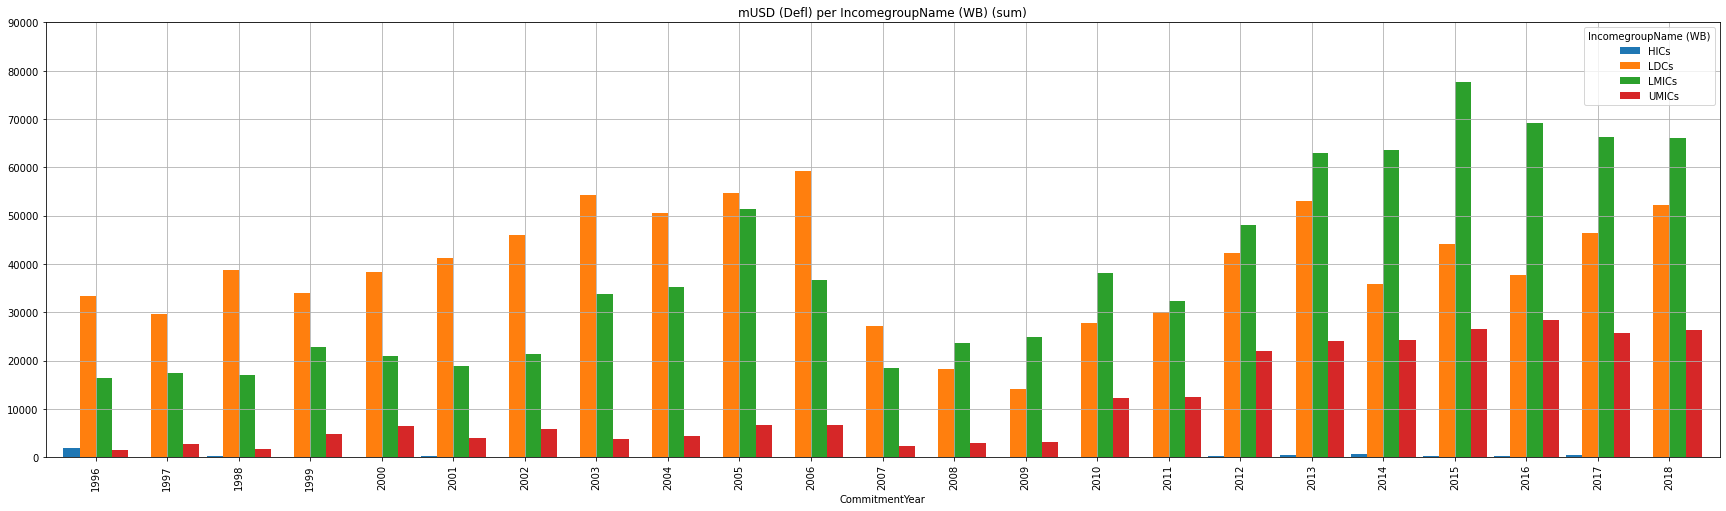

In [8]:
%%time

for igclassname in ["IncomegroupName","IncomegroupName (oecd hist)","IncomegroupName (WB)"]:

    groupeddf= df[df['CommitmentDate'] > datetime(year=1995,month=12,day=31)].set_index("CommitmentDate")
    #if igclassname != "IncomegroupName":
    #    groupeddf[igclassname].fillna( groupeddf['IncomegroupName'] + " (copy)",inplace=True)
    groupeddf = groupeddf.groupby([Grouper(freq="A"), igclassname])['USD_Commitment_Defl']

    # resolve grouping, unstack, fill missing and reset_index()
    groupeddf = groupeddf.sum().unstack().fillna(0.0).reset_index()

    # an absolut view
    # create index on year as string and drop old index
    groupeddf["CommitmentYear"]=groupeddf["CommitmentDate"].apply(lambda x: str(x.year))
    groupeddf = groupeddf.drop(columns=["CommitmentDate"]).set_index("CommitmentYear")

    # plot absolut sum
    groupeddf.plot(width=0.9,grid=True,kind='bar',
                   title="mUSD (Defl) per %s (sum)" %(igclassname),
                   figsize=(30,8),ylim=(0, 90000)
                   #color={"LDCs": "blue", "LMICs": "orange", "UMICs": "green","Other LICs": "black","MADCTs": "black"}
            )
    